In [1]:
import matflow as mf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from matplotlib import gridspec
import pandas as pd

from defdap.quat import Quat
from defdap import ebsd
from defdap import hrdic

import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [15]:
SIM_TYPE = 'micro_validated'
region = 'A3_zone2'

if SIM_TYPE == 'macro_validated':
    wk_path = {'A3_zone1':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220803.zip',
                     'A3_zone2':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220908.zip',
                     'A3_zone3':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220627.zip'}
elif SIM_TYPE == 'micro_validated':
    wk_path = {'A3_zone1':'E:/Matflow_exports/.zip',
                     'A3_zone2':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-07-05_115137.zip',
                     'A3_zone3':'E:/Matflow_exports/.zip'}

crop_data = {'A3_zone1':[292,363,335,195],
             'A3_zone2':[220,210,100,80],
             'A3_zone3':[190,271,168,135]}

k=5 # name contant


wk = mf.Workflow(wk_path[region])
#sim_elem.value
print(wk)

In [16]:
sim_elem = wk.tasks.simulate_VE_loading_damask.elements[0].outputs.VE_response
print(dir(sim_elem))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_app_attr', 'app', 'data_idx', 'data_idx_is_set', 'element', 'get_size', 'is_set', 'parent', 'path', 'task', 'value']


In [17]:
sim_elem = wk.tasks.simulate_VE_loading_damask.elements[0].outputs.VE_response
stress = sim_elem.value["phase_data"]["vol_avg_stress"]["data"]
strain = sim_elem.value["phase_data"]["vol_avg_strain"]["data"]

(0.0, 953.0152189989892)

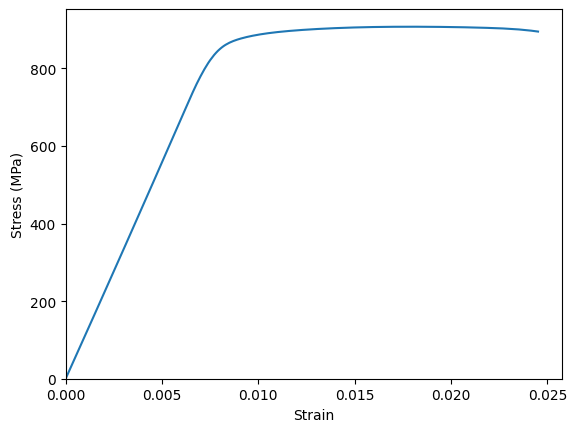

In [18]:
plt.figure()
plt.plot(strain[:, 0, 0], stress[:, 0, 0]/1e6)
#plt.plot(mean_strain, mean_stress/1e6)

plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.xlim([0, None])
plt.ylim([0, None])

#plt.savefig(r'stress_strain_curve_random orientation.png')

In [19]:
#np.save('mean_shear_strain_a3_zone2.npy',mean_shear_strain)

alpha = (np.pi/ 180) * -45
beta = (np.pi/ 180) * -45

rotation_matrix = [np.cos(alpha), -np.sin(beta), 0], [ np.sin(alpha), np.cos(beta), 0],[ 0, 0, 1]


partly_rotated_strain = np.einsum('...ij,jk->...ik', strain, rotation_matrix)
rotated_strain = np.einsum('...ij,ik->...kj',partly_rotated_strain, rotation_matrix)

### Effective shear strain

$\sqrt{\frac{(\sigma_{xx}-\sigma_{yy})^2}{2}+\sigma_{xy}^2}$

In [20]:
crop_data = {'A3_zone1':[292,363,335,195],
             'A3_zone2':[220,210,100,80],
             'A3_zone3':[190,271,168,135]}

## Plot field strain map

In [21]:
strain = sim_elem.value['field_data']['epsilon_U^0(F)']
strain = strain['data']
strain.shape

(10, 562, 321, 10, 3, 3)

In [22]:
inc = -1
z_layer = 7
buff_size_xy = crop_data[region]#(292,363,335,195)

map_slice = (inc, 
    slice(buff_size_xy[0], -buff_size_xy[1]), 
    slice(buff_size_xy[2], -buff_size_xy[3]), 
    z_layer) 
strain[map_slice].shape
cropped_strain = strain[map_slice]

In [23]:
#cropped_strain

In [24]:
rows = len(cropped_strain)
cols = len(cropped_strain[0,:])
shear_strain = np.zeros((rows, cols))
print(rows,cols)

132 141


In [25]:
# Iterate over each point in the grid
for i in range(rows):
    for j in range(cols):
        values = ((cropped_strain[i,j,0,0]-cropped_strain[i,j,1,1])**2/2 + cropped_strain[i,j,1,0]**2)**0.5
        shear_strain[i, j] = values

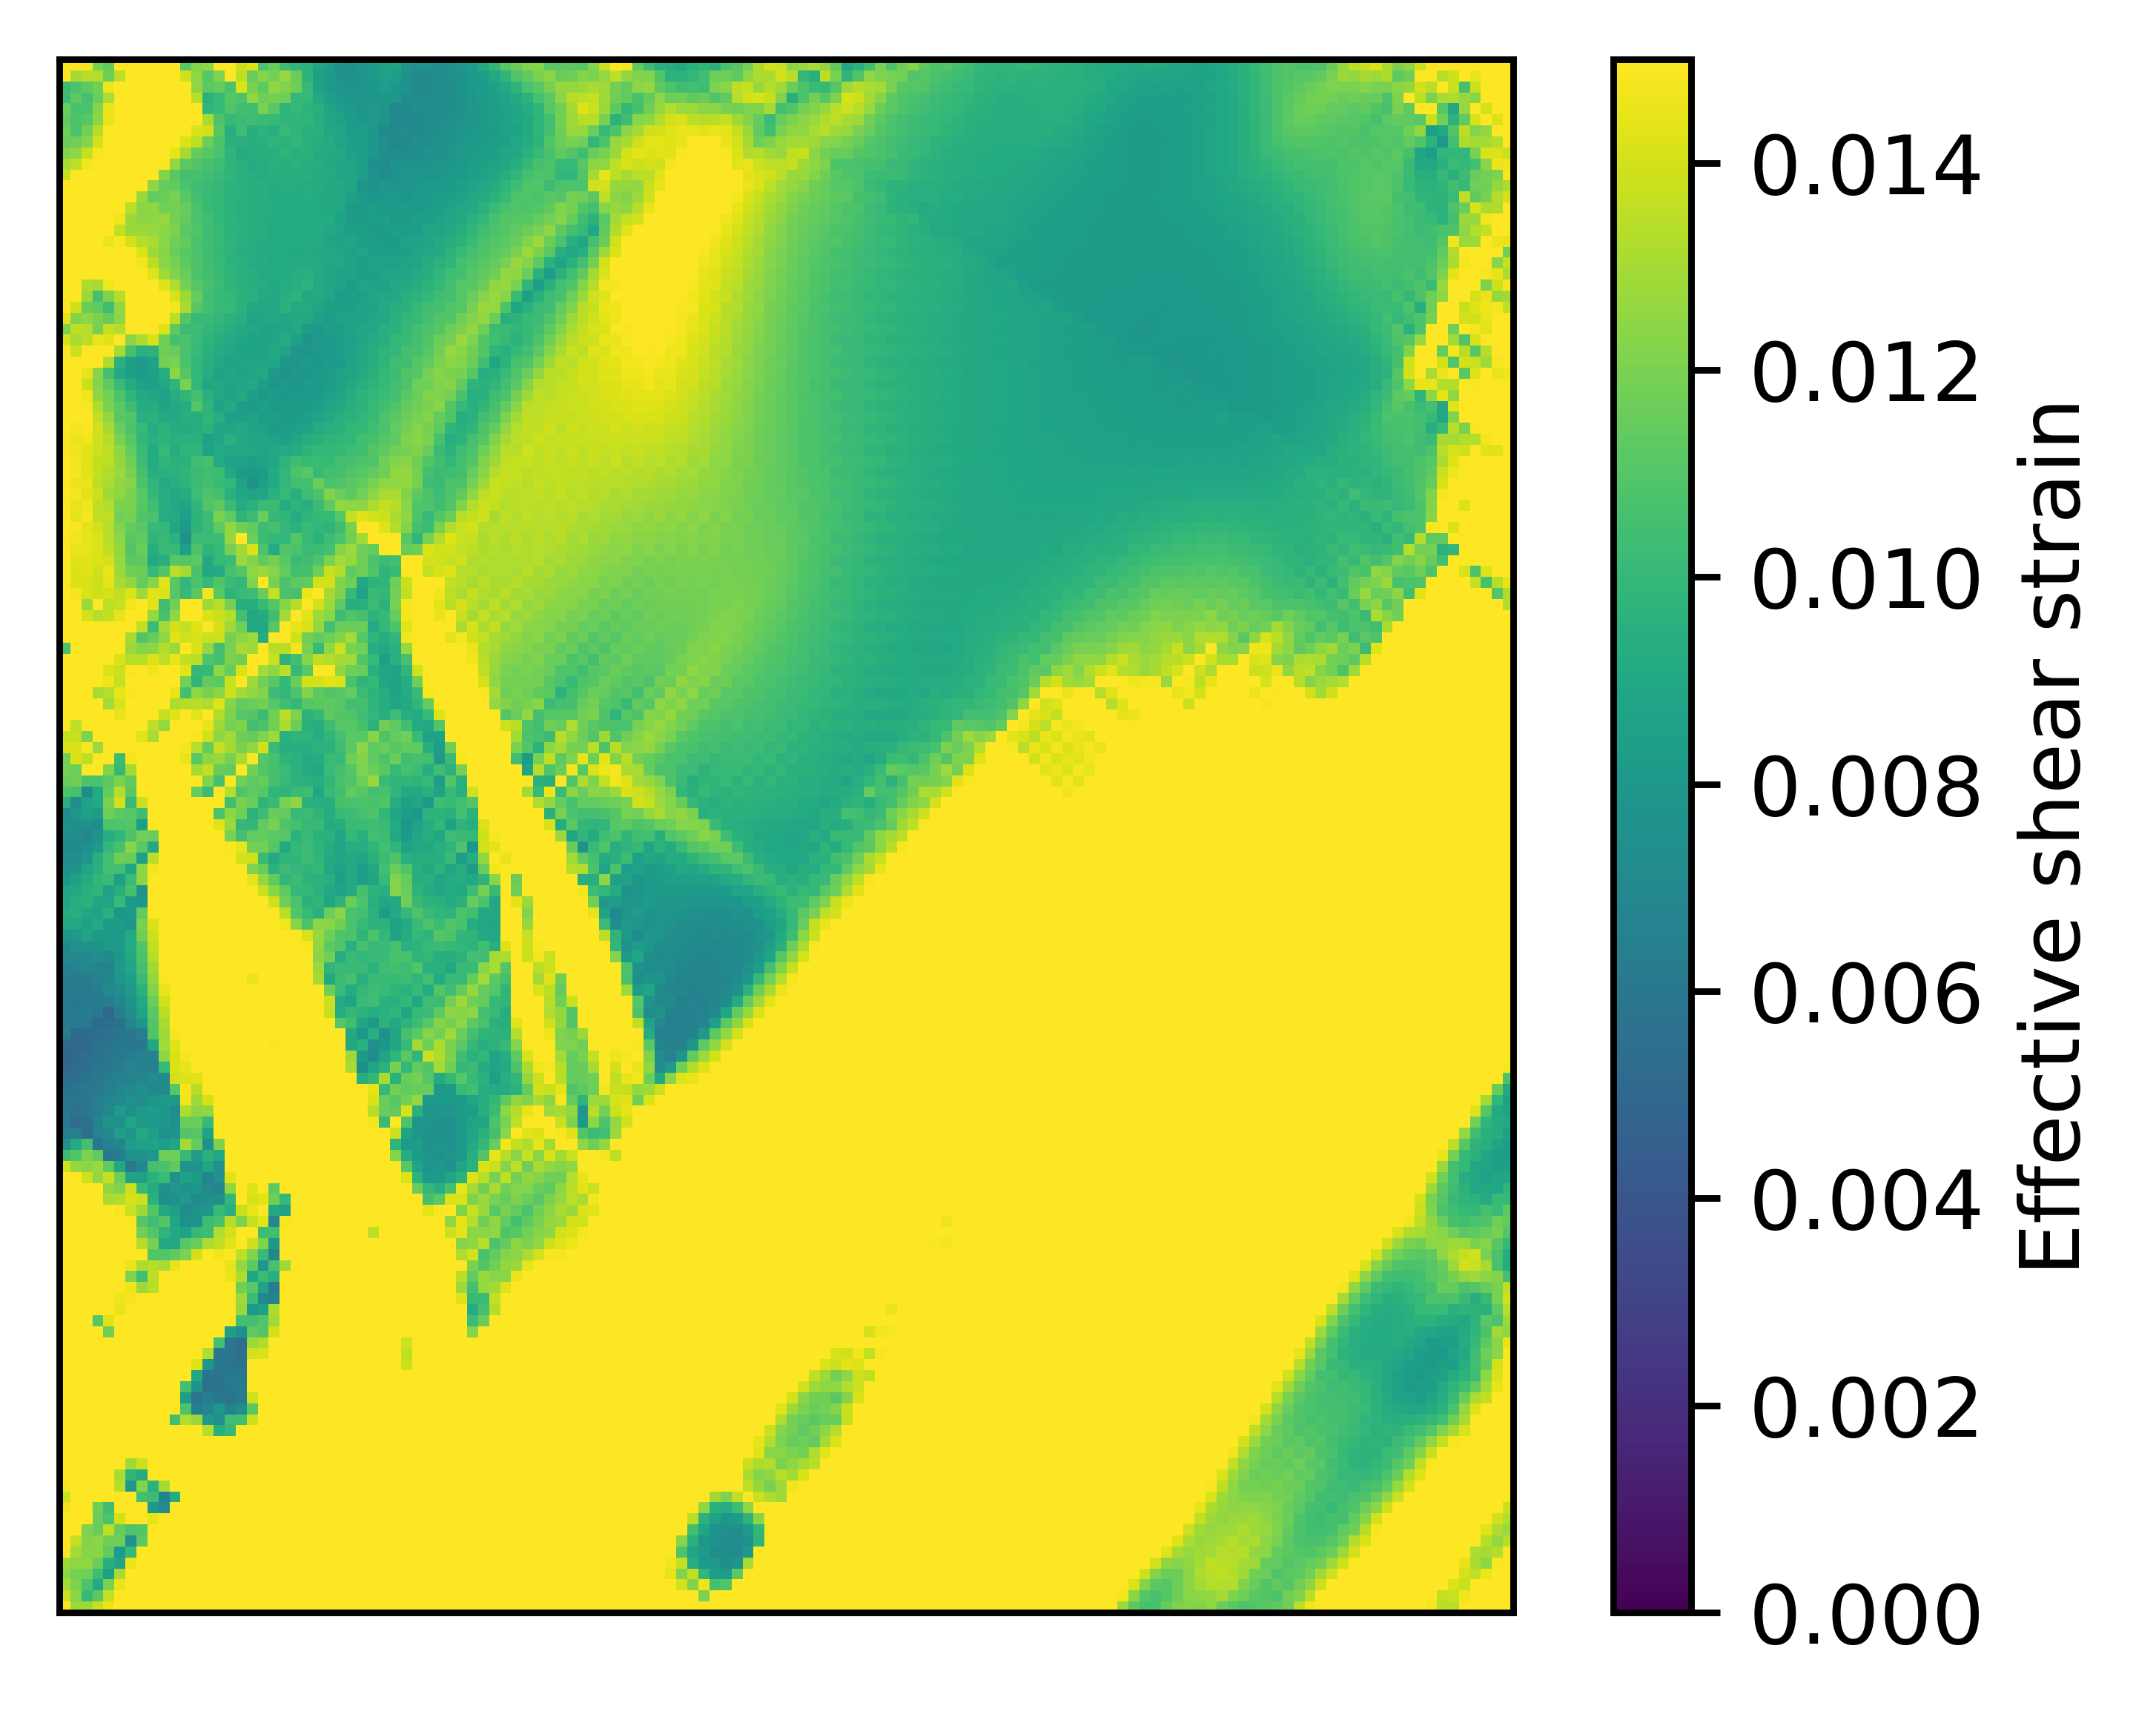

In [26]:
plt.figure(figsize=(4,3),dpi=800) #figsize=(3,2),dpi=1600
#plt.imshow( (strain[map_slice].T),vmin=0,vmax=0.015)
plt.imshow( (shear_strain.T),vmin=0,vmax=0.015)
plt.colorbar(label= 'Effective shear strain')
plt.xticks([])
plt.yticks([])


plt.tight_layout()
#plt.savefig(output+ 'A3_zone1_CP_ESS_{}.png'.format(step))

## Grain average strain

In [27]:
strain = sim_elem.value['grain_data']['epsilon_U^0(F)']
print(strain['meta']['increments'])

strain = strain['data']
print(strain.shape)

[36, 44, 50, 56, 67, 84, 105, 139, 187, 243]
(10, 199, 3, 3)


In [28]:
strain[9].shape

(199, 3, 3)

In [29]:
strain2 = strain[-1]
shear_strain=[]
#n=0
for i in range(0,len(strain2)):
    shear_strain.append( ( ( strain2[i, 0, 0] - strain2[i,1,1] )**2/2 + strain2[i,1,0]**2  )**0.5 )
   # n=+1
np.array(shear_strain).shape
#shear_strain

(199,)

In [30]:
grain_map = sim_elem.value['field_data']['grain']['data']
shear_strain_map = np.zeros_like(grain_map,dtype=float) # making a grain map with zero strains
for i_grain in np.unique(np.array(grain_map)):
    shear_strain_map[np.array(grain_map) == i_grain] = shear_strain[i_grain]
#shear_strain_map

In [31]:
type(np.array(grain_map))

numpy.ndarray

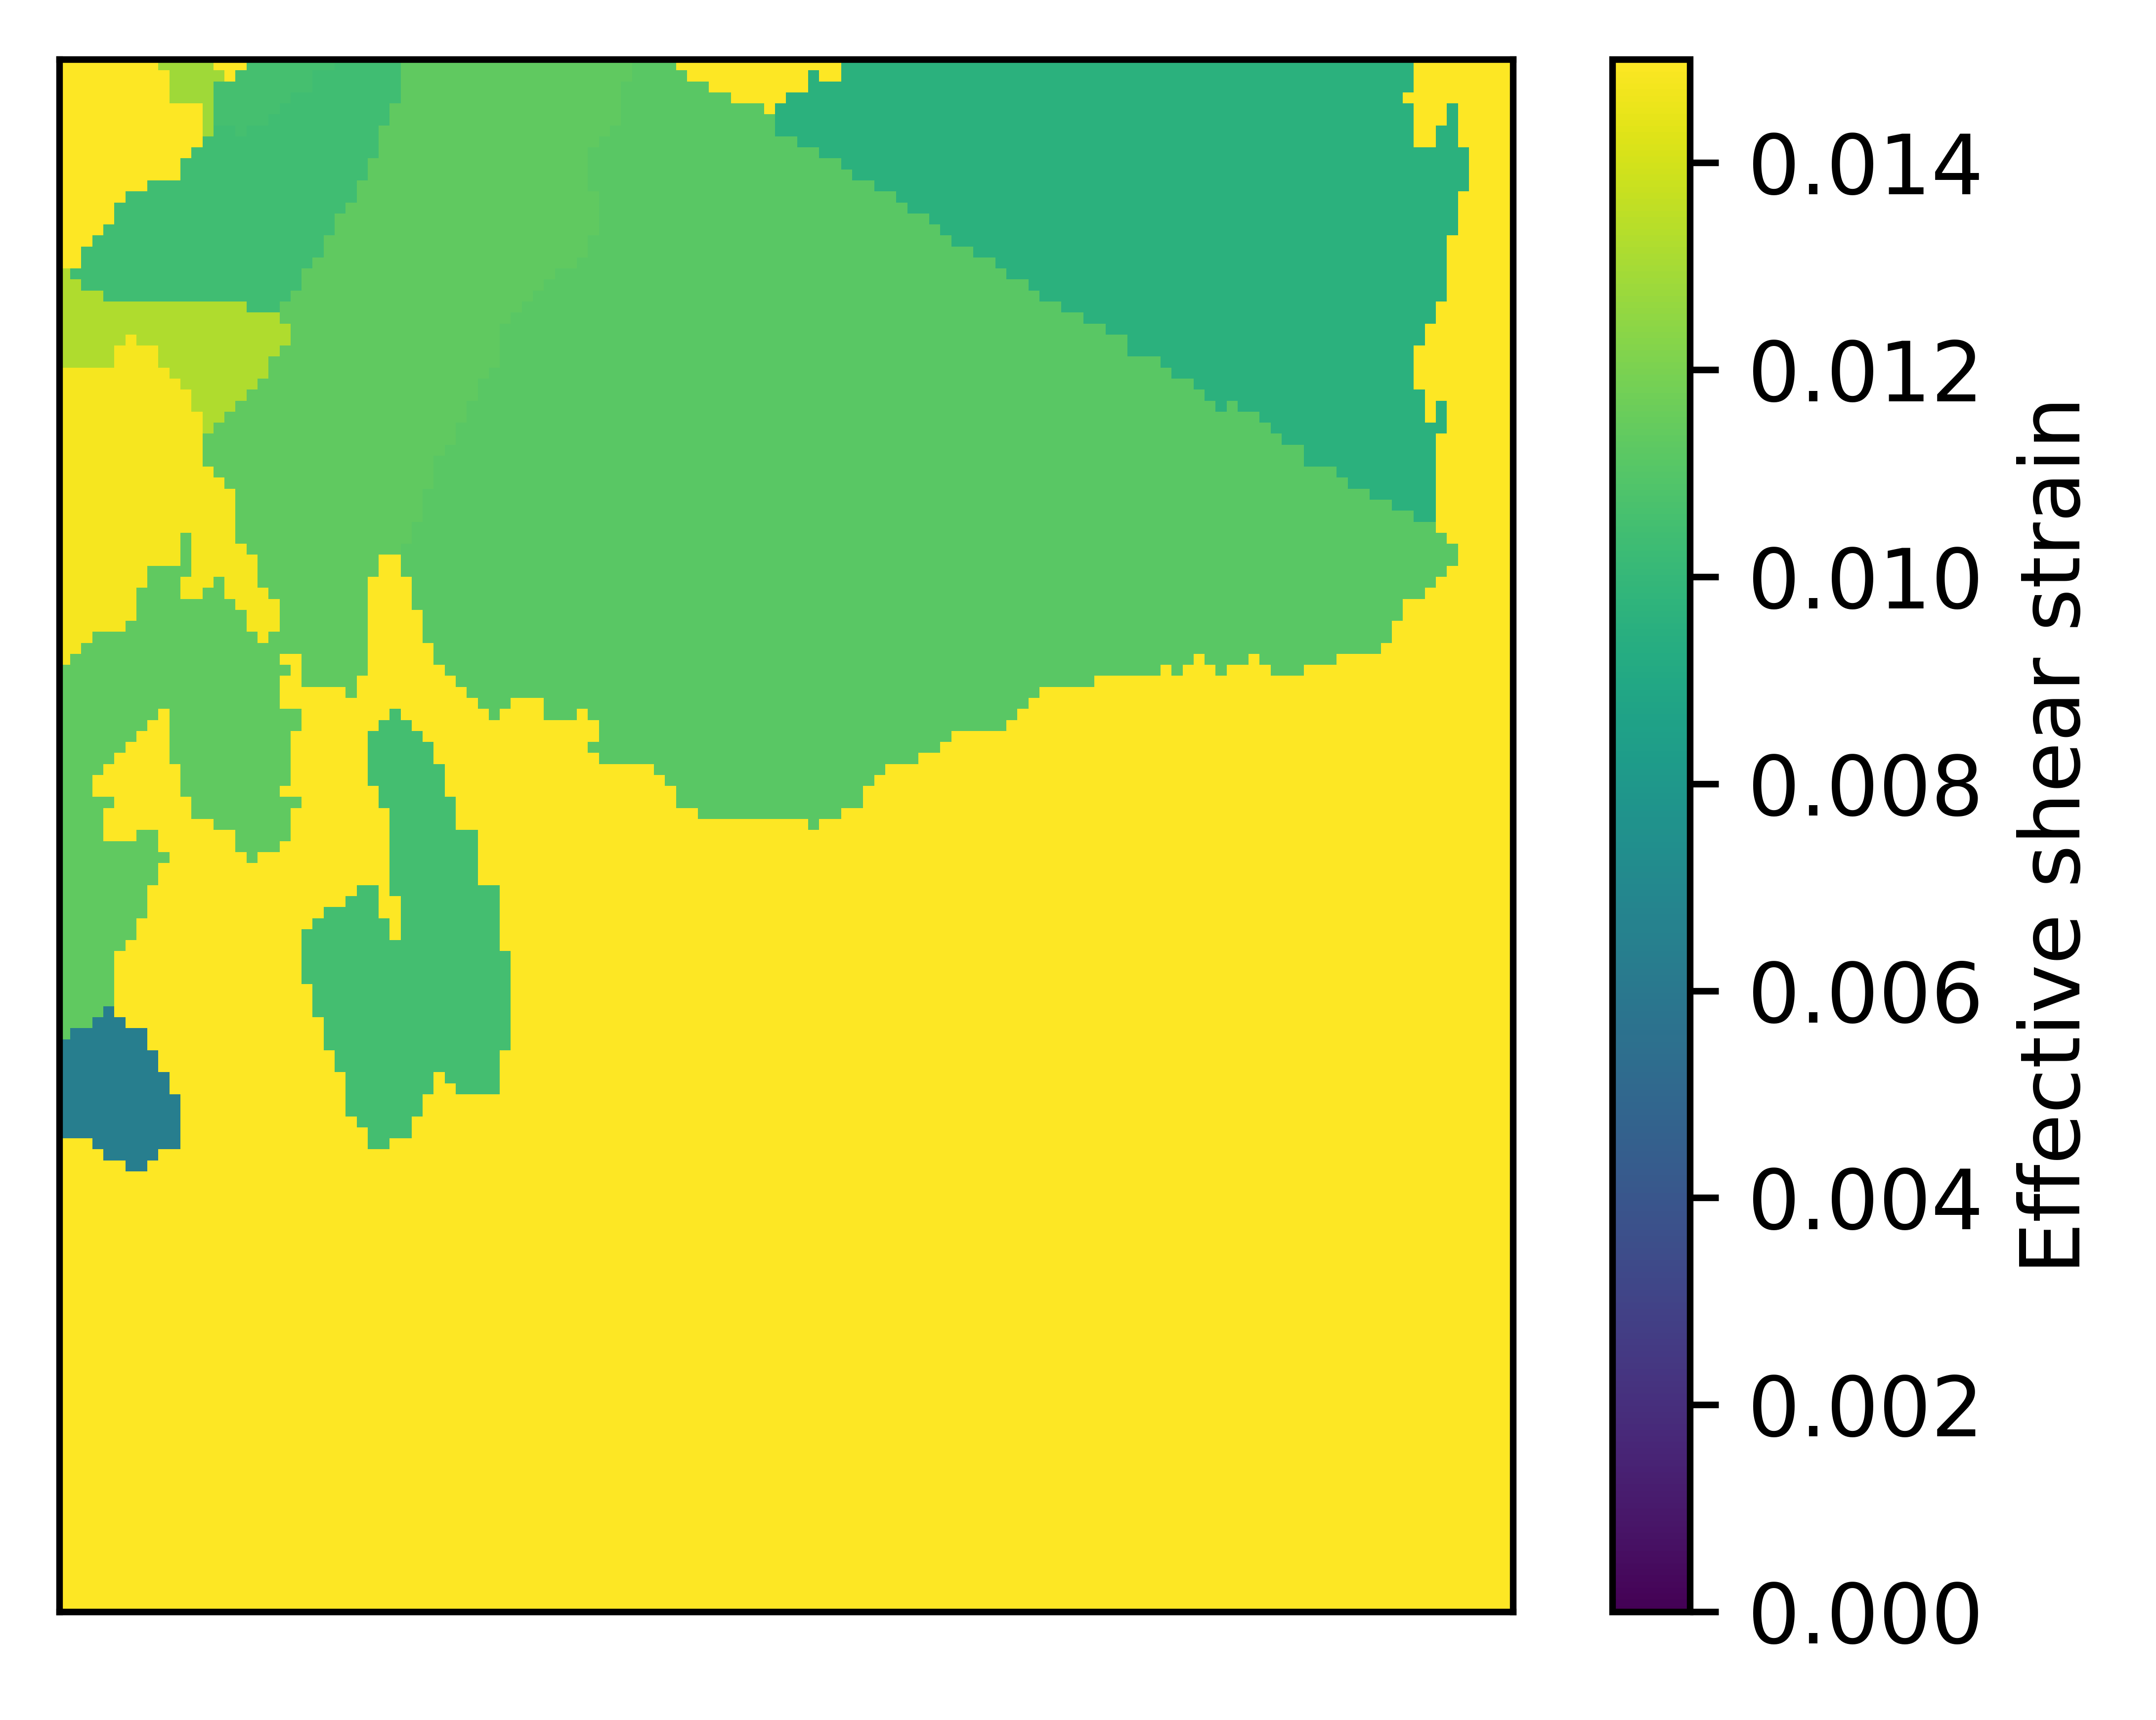

In [32]:
z_layer = 7
buff_size_xy = (crop_data[region][0],crop_data[region][1],crop_data[region][2],crop_data[region][3])
#buff_size_xy = (292,363,335,195)
map_slice = (slice(buff_size_xy[0], -buff_size_xy[1]), slice(buff_size_xy[2], -buff_size_xy[3]), z_layer)   

plt.figure(figsize=(4,3),dpi=1200) #figsize=(3,2),dpi=1600
plt.imshow( (shear_strain_map[map_slice].T),vmin=0,vmax=0.015)
plt.colorbar(label='Effective shear strain')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
#plt.savefig(output+ 'CP_grain_ESS_{}.png'.format(step))

#292,363,335,195    #A3_zone1
#220,210,100,80     #A3_zone2
#190,271,168,135    #A3_zone3
z_layer = 7
tensor_comp = (0,0) #(0,0)
buff_size_xy = (292,363,335,195)
#scaling = 0.687


map_slice = (
     
    slice(buff_size_xy[0], -buff_size_xy[1]), 
    slice(buff_size_xy[2], -buff_size_xy[3]), 
    z_layer
) 

plt.figure(figsize=(4,3),dpi=1200) #figsize=(3,2),dpi=1600
plt.imshow( (e11_strain_map[map_slice].T),vmin=0,vmax=0.015)
#plt.imshow( (shear_strain[map_slice].T)*scaling,vmin=0,vmax=0.01)
plt.colorbar(label=' Strain')
plt.xticks([])
plt.yticks([])
plt.title('E11')

plt.tight_layout()
#plt.savefig('A3_zone1_final_step_1_5.png')

In [33]:
file_name = "{}_strain_DIC.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    strain_comparison = pickle.load(pickle_file)

# Now, 'loaded_dict' contains the dictionary that was saved in the Pickle file
#print(strain_comparison)

In [34]:
#strain_comparison['step_11']

In [35]:
grain_id = strain_comparison['step_11']['grain_ID']
SIM_ESS = []
SIM_e11 = []
for i in grain_id:
    SIM_ESS.append(shear_strain[i])
    #SIM_e11.append(e11_strain[i])
#SIM_ESS

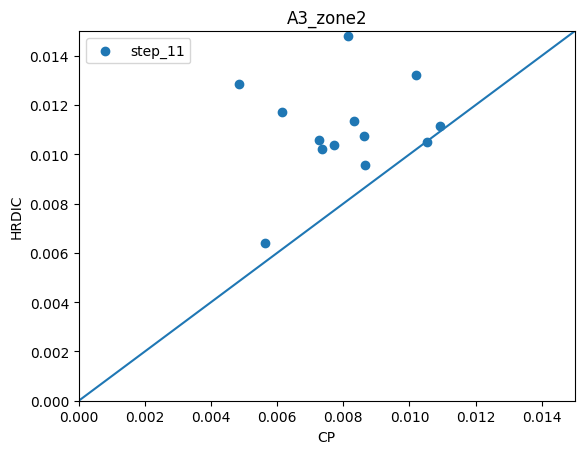

In [36]:
x = np.linspace(0, 0.015, 100)
y=x

plt.figure()#figsize=(8,8),dpi=600)
plt.scatter(strain_comparison['step_11']['DIC_shear_strain'],SIM_ESS,label='step_11')
plt.plot(x, y)
plt.xlim(0,0.015)
plt.ylim(0,0.015)
plt.ylabel('HRDIC')
plt.xlabel('CP')
plt.title('{}'.format(region))
plt.legend()

In [37]:
len(strain)
k = 5 #naming contanst
shear_strain_comparison = {}
for steps in range(len(strain)):
    strain2 = strain[steps]
    sim_shear_strain=[]
    for i in range(0,len(strain2)):
        sim_shear_strain.append( ( ( strain2[i, 0, 0] - strain2[i,1,1] )**2/2 + strain2[i,1,0]**2  )**0.5 )
    SIM_ESS = []
    SIM_e11 = []
    for m in grain_id:
        SIM_ESS.append(sim_shear_strain[m])
        #SIM_e11.append(e11_strain[m])
   # print(SIM_ESS)
    step = steps + k
    CP_shear_strain = {'step_{}'.format(step):SIM_ESS}
    shear_strain_comparison.update(CP_shear_strain)
#len(shear_strain_comparison['step_11'])

In [38]:
strain_comparison['step_11'].keys()

dict_keys(['grain_ID', 'grain_size ($\\mu m^2$)', 'DIC_e11', 'DIC_shear_strain'])

In [39]:
combined_ess = {}
k = 5 #naming contanst
for steps in range(len(shear_strain_comparison)):
    step = steps + k
    sim_ess = shear_strain_comparison['step_{}'.format(step)]
    exp_ess = strain_comparison['step_{}'.format(step)]['DIC_shear_strain']
    combined_ess['step_{}'.format(step)] = {'sim_ess':sim_ess,'exp_ess':exp_ess}
combined_ess['step_11'].keys()

dict_keys(['sim_ess', 'exp_ess'])

file_name = ("{0}_{1}_CP_ESS.pickle".format(region,SIM_TYPE))
with open(file_name, "wb") as pickle_file:
    pickle.dump(combined_ess, pickle_file)
1+1

In [30]:
width  = 3    /1000 #mm -> m
depth  = 1.75 /1000 #mm -> m
length = 10   *1000 #mm -> um

area = width * depth
force_at_image_a3 = [10,30,113,332,1451, 1896,2342,2791,3250,3707, 4131,4495,4714,4823, 4860, 4915,4946,4974,4988,5009]
exp_eng_stress_at_image_a3 = np.array(force_at_image_a3) / (area * 1000000)
stresses = (exp_eng_stress_at_image_a3[k-1:k+len(combined_ess.keys())-1])
stresses

array([276.38095238, 361.14285714, 446.0952381 , 531.61904762,
       619.04761905, 706.0952381 , 786.85714286, 856.19047619,
       897.9047619 , 918.66666667])

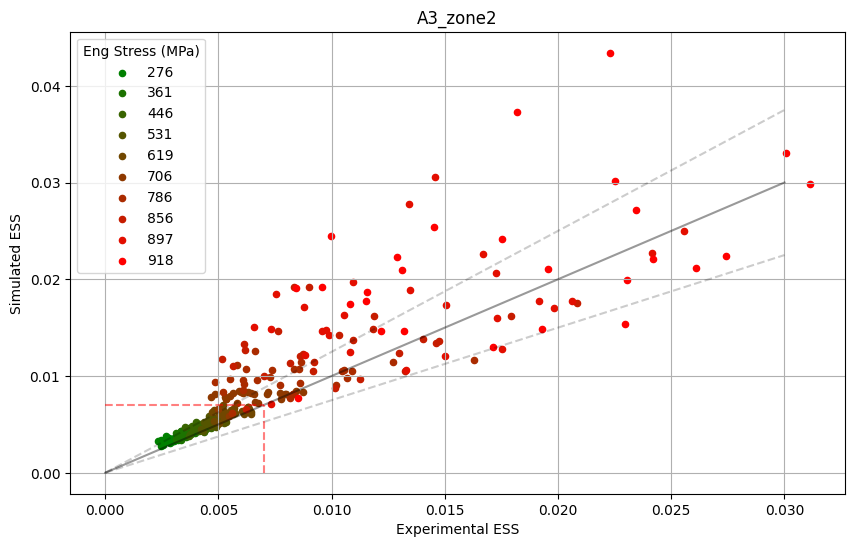

In [31]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom color map that transitions from blue to yellow
colors = ["green", "red"]
n_steps = len(combined_ess)
cmap = LinearSegmentedColormap.from_list("blue_yellow_gradient", colors, N=n_steps)

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot data for each step
#for idx, (step, data) in enumerate(combined_ess.items()):
#    exp_ess = data['exp_ess']
#    sim_ess = data['sim_ess']
#    stress_label = stresses[idx]
#    plt.scatter(exp_ess, sim_ess, color=colors(idx), label=int(stress_label),s=20)


# Plot data for each step
for idx, (step, data) in enumerate(combined_ess.items()):
    exp_ess = data['exp_ess']
    sim_ess = data['sim_ess']
    stress_label = stresses[idx]
    plt.scatter(exp_ess, sim_ess, color=cmap(idx / (n_steps - 1)), label=int(stress_label), s=20)



# Add plot details
plt.xlabel('Experimental ESS')
plt.ylabel('Simulated ESS')
plt.title(region)
plt.legend(title='Eng Stress (MPa)')
plt.grid(True)


x = np.linspace(0,0.03,100)
percentage_change = 25
y1 = x
y2 = (1+percentage_change/100) * x
y3 = (1-percentage_change/100) * x
plt.plot(x, y1, 'k-', alpha=0.4, label='y = x')
plt.plot(x, y2, 'k-', alpha=0.2,linestyle='--',label=r'$\pm$ 25%')#, label='y = x')
plt.plot(x, y3, 'k-', alpha=0.2,linestyle='--')#, label='y = x')

x_coords = [0, 0.007]
y_coords = [0.007, 0.007]
plt.plot(x_coords, y_coords, color='r', alpha=0.5, linestyle='--', label='Elastic limit')
plt.plot(y_coords, x_coords, color='r', alpha=0.5, linestyle='--')

# Show the plot
#plt.savefig('{}_old_strain_strain_region.png'.format(region))
#plt.show()



In [41]:
file_name = "{}_micro_validated_CP_ESS.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    micro_validated = pickle.load(pickle_file)
    
file_name = "{}_macro_validated_CP_ESS.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    macro_validated = pickle.load(pickle_file)

In [46]:
macro_sim_ess_values = [macro_validated[step]['sim_ess'] for step in macro_validated]
micro_sim_ess_values = [micro_validated[step]['sim_ess'] for step in micro_validated]

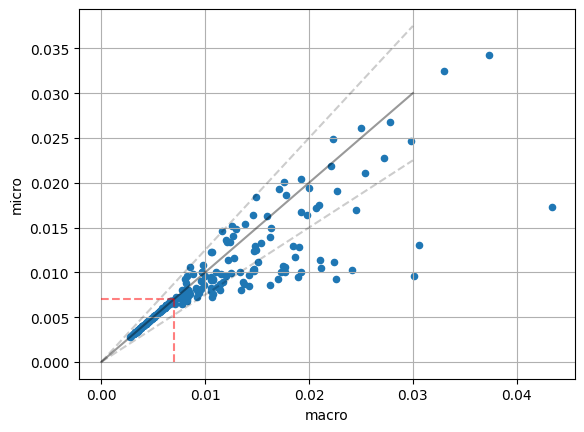

In [50]:
plt.scatter(macro_sim_ess_values,micro_sim_ess_values,s=20)
plt.xlabel('macro')
plt.ylabel('micro')
plt.grid(True)


x = np.linspace(0,0.03,100)
percentage_change = 25
y1 = x
y2 = (1+percentage_change/100) * x
y3 = (1-percentage_change/100) * x
plt.plot(x, y1, 'k-', alpha=0.4, label='y = x')
plt.plot(x, y2, 'k-', alpha=0.2,linestyle='--',label=r'$\pm$ 25%')#, label='y = x')
plt.plot(x, y3, 'k-', alpha=0.2,linestyle='--')#, label='y = x')

x_coords = [0, 0.007]
y_coords = [0.007, 0.007]
plt.plot(x_coords, y_coords, color='r', alpha=0.5, linestyle='--', label='Elastic limit')
plt.plot(y_coords, x_coords, color='r', alpha=0.5, linestyle='--')
plt.savefig('{}_macro_micro_strain_strain_region.png'.format(region))

# code from Dongchen

In [35]:
def get_slipsystem_activity(grainID,EBSDMap):
    
    #Load the slip systems for the current phase
    ssGroup = EBSDMap[grainID].phase.slipSystems

    #Calculate the schmid factor of each slip system
    SchmidFactor = EBSDMap[grainID].averageSchmidFactors

    ##Calculate the slip trace angles
    #DicMap[grainID].ebsdGrain.calcSlipTraces()
    #ST_Angle=np.rad2deg(DicMap[grainID].ebsdGrain.slipTraceAngles)

    # print the slip plane of each trace, the max Schmid factor of it and its angle (by degree)

    info_frame = []
    for i in range(0,4):
        
        info_frame.append([])
        info_frame[i].append('Slip plane {0} :'.format(i+1))
        info_frame[i].append(ssGroup[i][0].slipPlaneLabel)
        info_frame[i].append('| SF:')
        SF_round = round(max(SchmidFactor[i]),3)
        info_frame[i].append(SF_round)
        #info_frame[i].append('| Angle:')
        #angle_round = round(ST_Angle[i],3)
        #info_frame[i].append(angle_round)
        #print('Slip plane {0}:'.format(i+1),ssGroup[i][0].slipPlaneLabel,'| SF:',max(SchmidFactor[i]),'| Angle:',ST_Angle[i])
    #print(info_frame)

    #Order the slip planes by the Schmid Factor
    info_frame = sorted(info_frame, reverse=True, key = lambda x: (x[3]))
    #print(info_frame)
    
    Theo_Plane = []
    #SF_list = []
    #print(len(info_frame))
    
    for i in range(0,len(info_frame)):
        #theo_angle.append(info_frame[i][5])
        #SF_list.append(info_frame[i][3])
        Theo_Plane.append(info_frame[i][0])
    return Theo_Plane

## sum slip activity of each grain

In [36]:
ori = sim_elem.value['grain_data']['O']
print(ori['meta']['increments'])
ori_data = ori['data']['quaternions']
#print(ori_data.shape)
#np.save('A3_zone2_ori_data.npy',ori_data['quaternions'])

[0]


In [37]:
ori['data'].keys()

dict_keys(['quaternions', 'type', 'unit_cell_alignment', 'quat_component_ordering', 'P'])

In [38]:
ori['data']['P']

-1

In [20]:
EbsdFilePath = "../EBSD_data/CP large area/{}".format(region)
EbsdMap = ebsd.Map(EbsdFilePath) #delete 'cubic'
#EbsdMap.rotateData()
EbsdMap.buildQuatArray()
EbsdMap.findBoundaries(boundDef = 2) #degrees
EbsdMap.findGrains(minGrainSize = 5) #pixels
EbsdMap.calcGrainMisOri(calcAxis = False)
EbsdMap.calcAverageGrainSchmidFactors(loadVector=[1,0,0])

Starting loading EBSD data..
Unknown field in file with key 51. Assumming float32 data.
Loaded EBSD data (dimensions: 554 x 313 pixels, step size: 3.5 um)
Finished building quaternion array (0:00:00) 
Finished finding grain boundaries (0:00:00) 
Finished finding grains (0:00:00) 
Finished calculating grain misorientations (0:00:02) 
Finished calculating grain average Schmid factors (0:00:00) 


In [39]:
slip = sim_elem.value['grain_data']['gamma_sl']
print(slip['meta']['increments'])
slip_data = slip['data']
print(slip_data.shape)
#np.save('A3_zone2_slip_data.npy',slip_data)

[33, 43, 51, 56, 63, 70, 84, 114, 155, 199]
(10, 545, 18)


In [40]:
from defdap import defaults

In [41]:
defaults['crystal_ortho_conv'] = 'hkl'

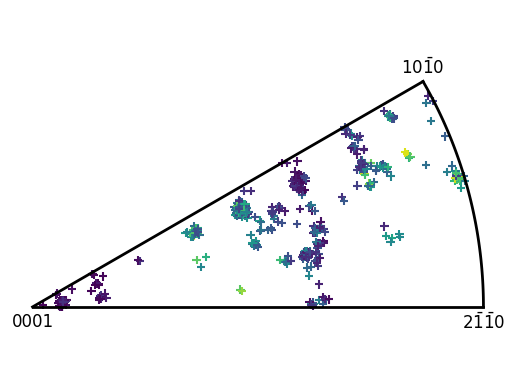

In [52]:
ori_data = np.load('A3_zone2_ori_data.npy')
slip_data = np.load('A3_zone2_slip_data.npy')

quats = np.empty(ori_data.shape[:-1], dtype=object)
for idx in np.ndindex(ori_data.shape[:-1]):
    quats[idx] = Quat(ori_data[idx]).conjugate

i_ts = 8

plot = Quat.plotIPF(quats[i_ts], [1,0,0], symGroup='hexagonal', c=slip_data.max(axis=2)[i_ts])

In [48]:
def get_activated(slip_data, yield_strain, grainID): #yield_strain %
    slip_dic = {}

    for n in range(slip_data.shape[0]):  
        step_key = f'step{n}'  
        grain_dict = {}

        for i in grainID: 
            grain_key = i  #
            indices_greater_than_yield = []  

            slip_data_value = slip_data[n, i, :] * 100  

            for index, value in enumerate(slip_data_value):
                if value >= yield_strain:
                    indices_greater_than_yield.append(index)

            grain_dict[grain_key] = indices_greater_than_yield

        slip_dic[step_key] = grain_dict

    return slip_dic

# Example usage:
#slip_data = np.load('A3_zone2_slip_data.npy')  # Your 3D NumPy array
#custom_yield_strain = 0.8 #percent
#custom_slip_data_row_indices = [50, 100, 150]
##result = get_activated(slip_data, custom_yield_strain, custom_slip_data_row_indices)
#result

In [49]:
def sort_systems(data_dict):
    bas_list = []
    pris_list = []
    pyra_a_list = []
    pyra_ac_list = []

    for step, values_dict in data_dict.items():
        for key, values in values_dict.items():
            for value in values:
                # Check your condition here, for example, if the value is 5
                if not value:
                    pass
                elif value <= 2:
                    bas_list.append(key)
                elif 2 < value <= 5:
                    pris_list.append(key)
                elif 5 < value <= 11:
                    pyra_a_list.append(key)
                elif 11 < value <= 23:
                    pyra_ac_list.append(key)
                else:
                    raise ValueError(f"Error: Index not found or out of range, range=(0:24). Grain ID: {grain_id}, Step: {step}")

    # Unique keys where the condition is met
    bas_list = list(set(bas_list))
    pris_list = list(set(pris_list))
    pyra_a_list = list(set(pyra_a_list))
    pyra_ac_list = list(set(pyra_ac_list))

    return bas_list, pris_list, pyra_a_list, pyra_ac_list

# Example usage:
#bas_list, pris_list, pyra_a_list, pyra_ac_list = process_values_dict(data_dict)


In [50]:
def get_activated(slip_data, yield_strain, grainID): #yield_strain %
    slip_dic = {}

    for n in range(slip_data.shape[0]):  
        step_key = f'step{n}'  
        grain_dict = {}

        for i in grainID: 
            grain_key = i  #
            indices_greater_than_yield = []  

            slip_data_value = slip_data[n, i, :] * 100  

            for index, value in enumerate(slip_data_value):
                if value >= yield_strain:
                    indices_greater_than_yield.append(index)

            grain_dict[grain_key] = indices_greater_than_yield

        slip_dic[step_key] = grain_dict

    return slip_dic

def sort_systems(data_dict):
    bas_list = []
    pris_list = []
    pyra_a_list = []
    pyra_ac_list = []

    for step, values_dict in data_dict.items():
        for key, values in values_dict.items():
            for value in values:
                # Check your condition here, for example, if the value is 5
                if not value:
                    pass
                elif value <= 2:
                    bas_list.append(key)
                elif 2 < value <= 5:
                    pris_list.append(key)
                elif 5 < value <= 11:
                    pyra_a_list.append(key)
                elif 11 < value <= 23:
                    pyra_ac_list.append(key)
                else:
                    raise ValueError(f"Error: Index not found or out of range, range=(0:24). Grain ID: {grain_id}, Step: {step}")

    # Unique keys where the condition is met
    bas_list = list(set(bas_list))
    pris_list = list(set(pris_list))
    pyra_a_list = list(set(pyra_a_list))
    pyra_ac_list = list(set(pyra_ac_list))

    return bas_list, pris_list, pyra_a_list, pyra_ac_list

In [51]:
bas_list, pris_list, pyra_a_list, pyra_ac_list = sort_systems(data_dict)
bas_list

NameError: name 'data_dict' is not defined

In [53]:
def slip_systems_grainID(my_dict):
    bas_list=[]
    pris_list=[]
    pyra_a_list =[]
    pyra_ac_list =[]
    for step, grain_data in my_dict.items():
        for grain_id, index_list in grain_data.items():
            if index_list:
                for i in range(len(index_list)):
                    index = index_list[i]
                    if index <= 2:
                        index_list[i] = 'basal'
                    elif 2 < index <= 5:
                        index_list[i] = 'prismatic'
                    elif 5 < index <= 11:
                        index_list[i] = 'pyramidal <a>'
                    elif 11 < index <= 23:
                        index_list[i] = 'pyramidal <a+c>'
                    else:
                        raise ValueError(f"Error: Index not found or out of range, range=(0:24). Grain ID: {grain_id}, Step: {step}")

# Example usage:
my_dict = {'step8': {'grain50': [0], 'grain100': [2, 5], 'grain150': [23]}}
get_slip_name(my_dict)

# Print the updated dictionary
print(my_dict)


NameError: name 'get_slip_name' is not defined

In [245]:
ori_data = np.load('A3_zone2_ori_data.npy')
slip_data = np.load('A3_zone2_slip_data.npy')
slip_dic = get_activated(slip_data, yield_strain=0.7, slip_data_row_indices=[50,100,150])
system_dic = get_slip_name(slip_dic)

print(slip_dic)

{'step0': {50: [], 100: [], 150: []}, 'step1': {50: [], 100: [], 150: []}, 'step2': {50: [], 100: [], 150: []}, 'step3': {50: [], 100: [], 150: []}, 'step4': {50: [], 100: [], 150: []}, 'step5': {50: [], 100: [], 150: []}, 'step6': {50: [], 100: [], 150: []}, 'step7': {50: [], 100: [], 150: []}, 'step8': {50: [], 100: ['prismatic'], 150: ['prismatic']}}


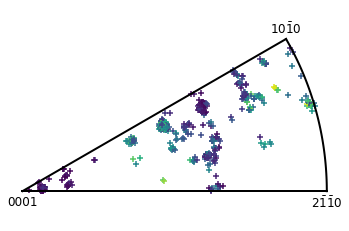

In [218]:
quats = np.empty(ori_data.shape[:-1], dtype=object)
for idx in np.ndindex(ori_data.shape[:-1]):
    quats[idx] = Quat(ori_data[idx]).conjugate

i_ts = 8

plot = Quat.plotIPF(quats[i_ts], [1,0,0], symGroup='hexagonal', c=slip_data.max(axis=2)[i_ts])

In [54]:
def calculate_grain_oris(ori_data, cpGrainIDs, i_ts):
    quats = np.empty(ori_data.shape[:-1], dtype=object)
    
    for idx in np.ndindex(ori_data.shape[:-1]):
        quats[idx] = Quat(ori_data[idx]).conjugate

    grainOris = quats[i_ts][cpGrainIDs]
    
    return grainOris

In [94]:
GrainID = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,600]
data_dict= get_activated(slip_data,yield_strain=0.2,grainID=GrainID)
bas_list, pris_list, pyra_a_list, pyra_ac_list = sort_systems(data_dict)
bas_list

[70, 90, 110]

In [96]:
all_ori = calculate_grain_oris(ori_data,GrainID,0)
bas_ori = calculate_grain_oris(ori_data,bas_list,0)
pris_ori = calculate_grain_oris(ori_data,pris_list,0)
pyra_a_ori = calculate_grain_oris(ori_data,pyra_a_list,0)
pyra_ac_ori = calculate_grain_oris(ori_data,pyra_ac_list,0)

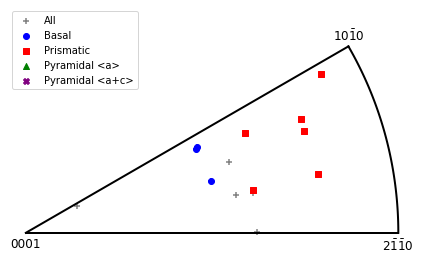

In [99]:
plot = Quat.plotIPF(all_ori, [1,0,0], symGroup='hexagonal',label='All',c='grey',marker='+') 
Quat.plotIPF(bas_ori, [1,0,0], symGroup='hexagonal',plot=plot,label='Basal',c='blue',marker='o') 
Quat.plotIPF(pris_ori, [1,0,0], symGroup='hexagonal',plot=plot,label='Prismatic',c='red',marker='s')
Quat.plotIPF(pyra_a_ori, [1,0,0], symGroup='hexagonal',plot=plot,label='Pyramidal <a>',c='green',marker='^')
Quat.plotIPF(pyra_ac_ori, [1,0,0], symGroup='hexagonal',plot=plot,label='Pyramidal <a+c>',c='purple',marker='X')
plt.legend(loc = 'upper left')
plt.tight_layout()

In [19]:
file_name = "{}_strain_comparison.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    strain_comparison = pickle.load(pickle_file)

# Now, 'loaded_dict' contains the dictionary that was saved in the Pickle file
#print(strain_comparison)

In [20]:
grain_id=[]
i=0
while i < len(strain_comparison['step_11'][:,0]):
    grain_id.append(int(strain_comparison['step_11'][:,0][i]))
    i=i+1

In [36]:
len(grain_id)

80

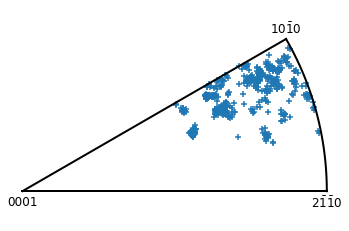

In [45]:
from defdap.quat import Quat
import numpy as np

ori_data = np.load('A3_zone2_ori_data.npy')
slip_data = np.load('A3_zone2_slip_data.npy')

quats = np.empty(ori_data.shape[:-1], dtype=object)
for idx in np.ndindex(ori_data.shape[:-1]):
    quats[idx] = Quat(ori_data[idx])

i_ts = 0

plot = Quat.plotIPF(quats[i_ts], [1,0,0], symGroup='hexagonal')#c=slip_data.max(axis=2)[i_ts]


In [90]:
count_basal = slip_system.count('basal')
count_prismatic = slip_system.count('prismatic')
count_pyramidal = slip_system.count('pyramidal a+c')

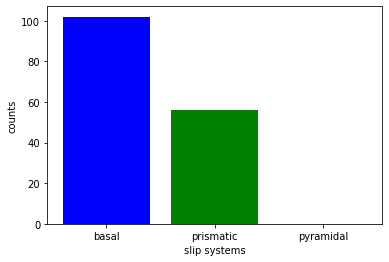

In [94]:
categories = ['basal', 'prismatic', 'pyramidal']
values = [count_basal, count_prismatic, count_pyramidal]  # Replace with your actual values

plt.bar(categories, values, color=['blue', 'green', 'red'])
plt.xlabel('slip systems')
plt.ylabel('counts')
plt.show()

In [8]:
step = 9
crop_data = {'A3_zone1':[292,363,335,195],
             'A3_zone2':[220,210,100,80],
             'A3_zone3':[190,271,168,135]}
region = 'A3_zone2'

In [9]:
plot_maps =True

Size of cropped_strain: (132, 143, 3, 3)
132 143


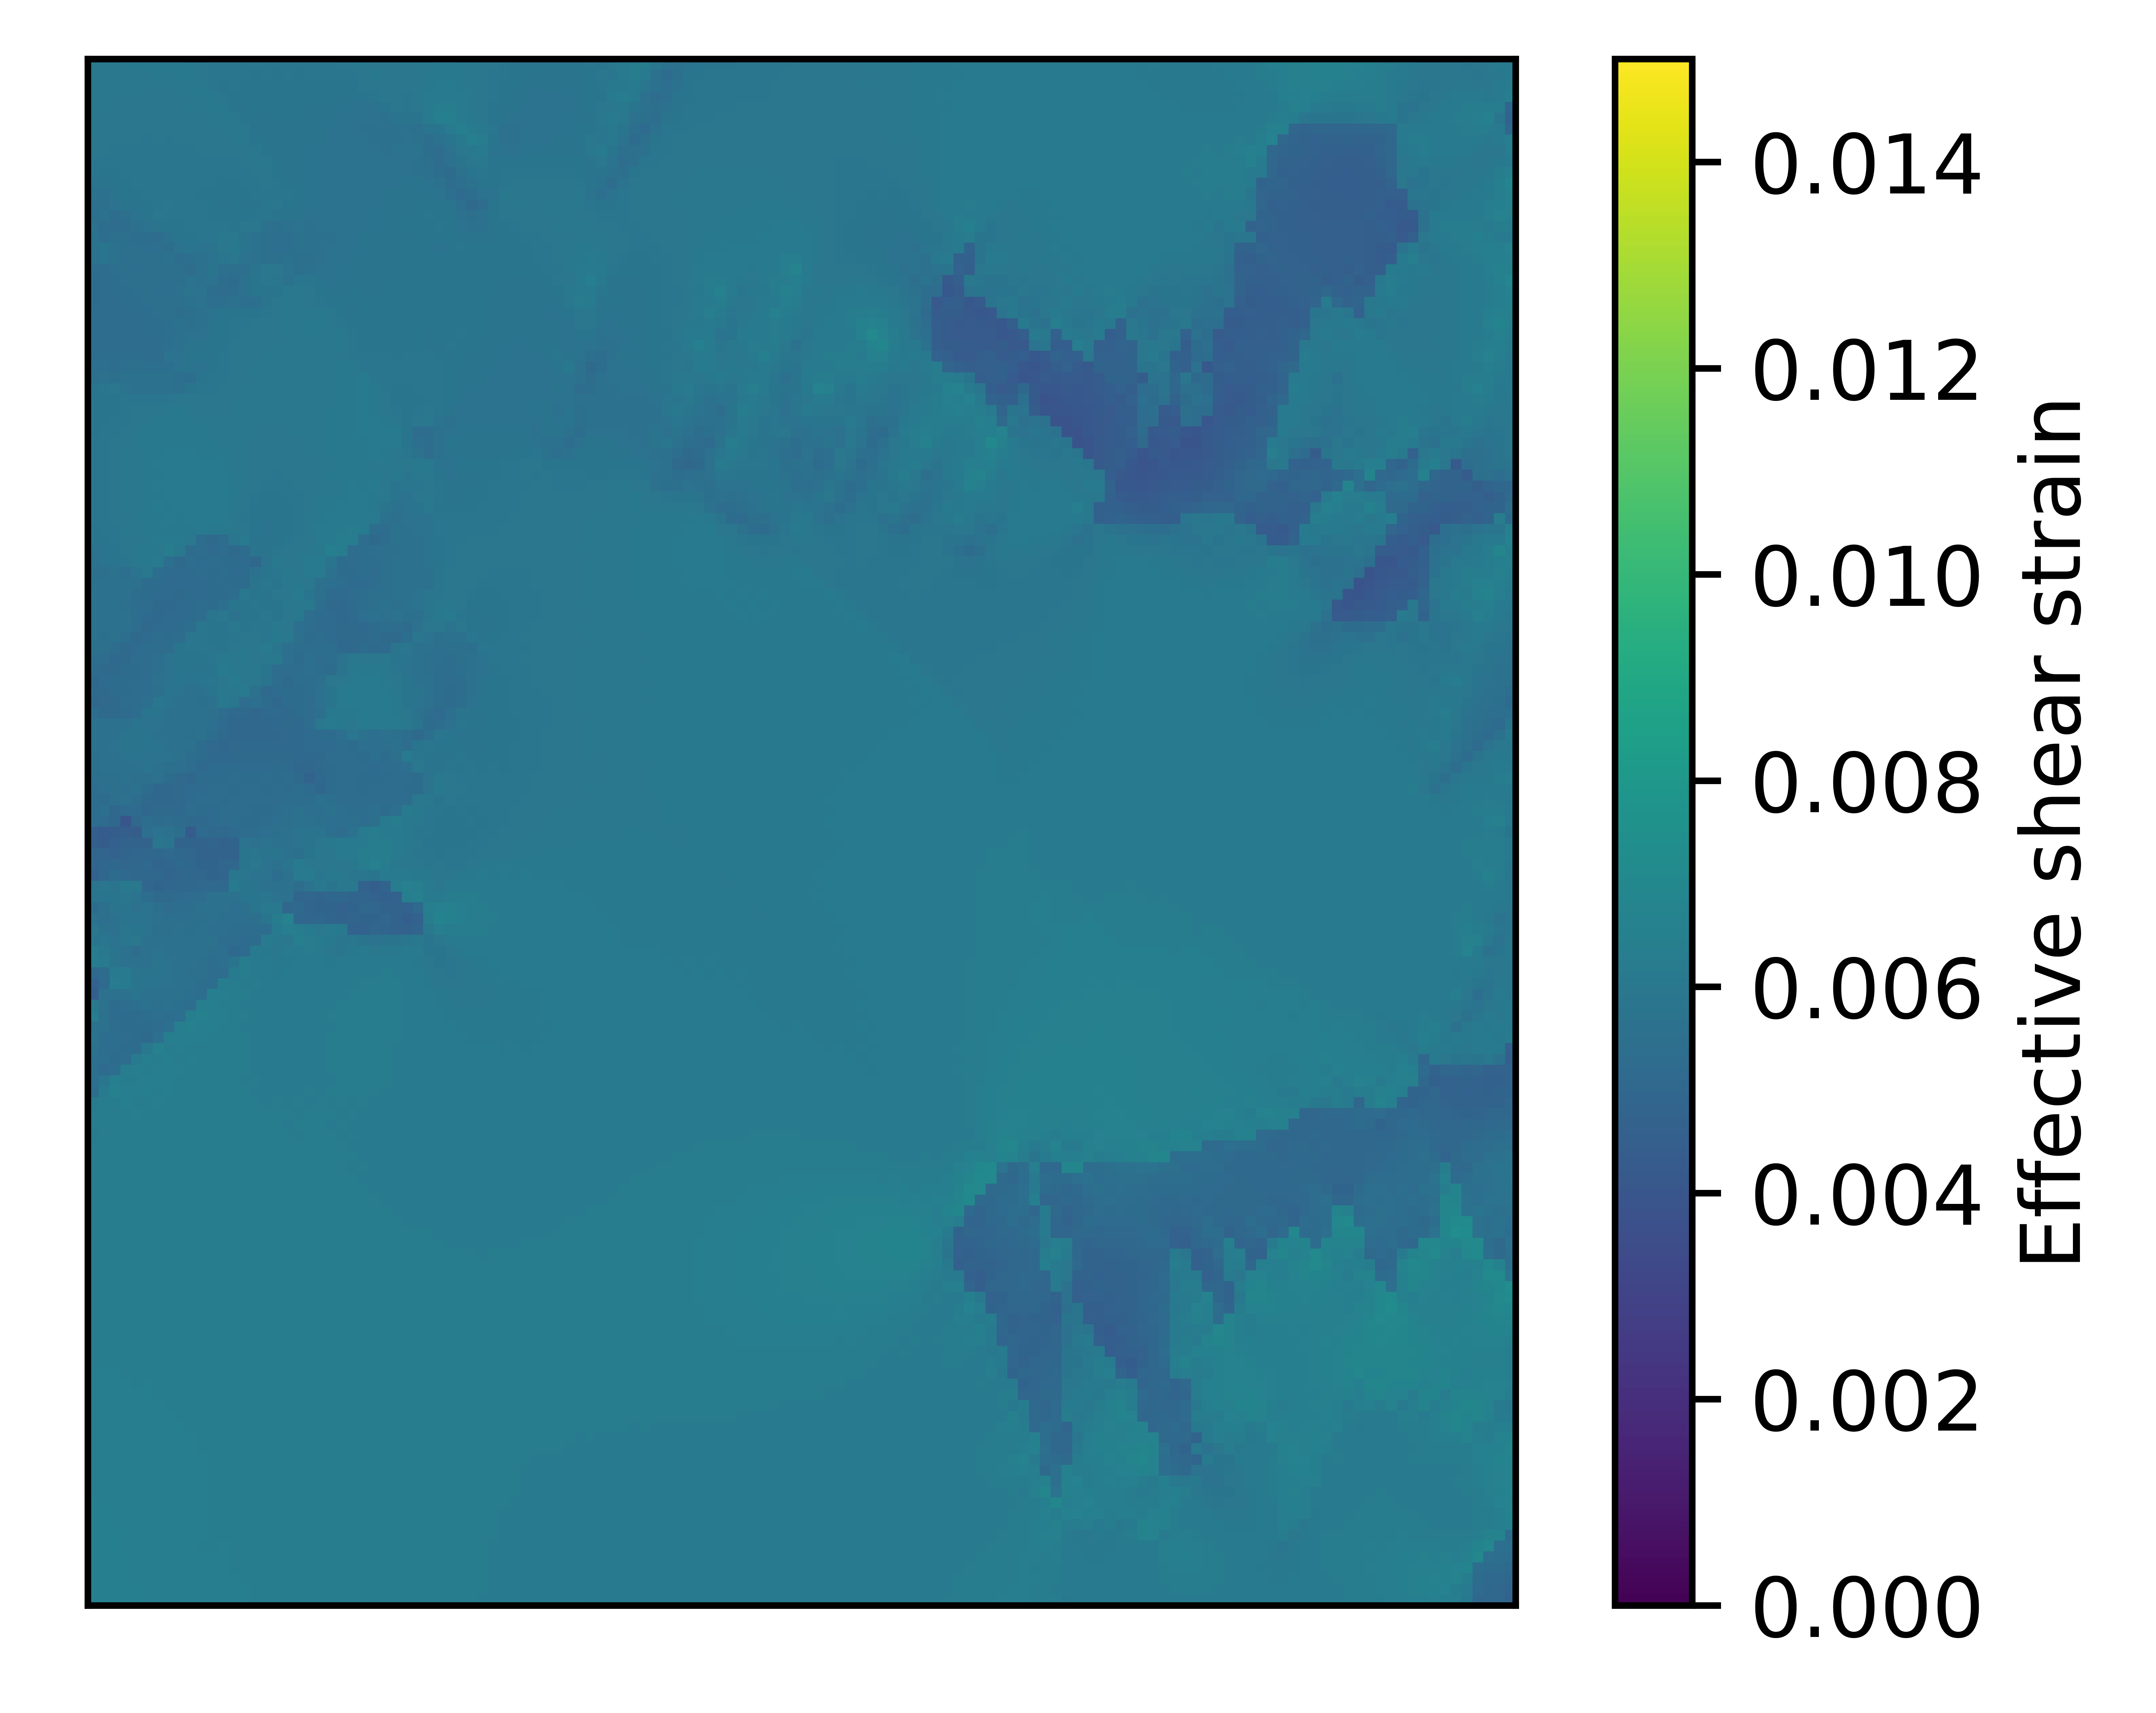

In [29]:
step=5
if plot_maps:
        strain_field = vol_elem_resp['field_data']['epsilon_U^0(F)']['data']
        strain_field2 = strain_field[step]
        z_layer = 7
        buff_size_xy = crop_data[region]#(292,363,335,195)
        map_slice = (slice(buff_size_xy[0], -buff_size_xy[1]), slice(buff_size_xy[2], -buff_size_xy[3]), z_layer) 
        cropped_strain = strain_field2[map_slice]
        print("Size of cropped_strain:", cropped_strain.shape)

        rows = len(cropped_strain)
        cols = len(cropped_strain[0,:])
        print(rows,cols)
        shear_strain = np.zeros((rows, cols)) 
        
        for i in range(rows):
            for j in range(cols):
                values = ((cropped_strain[i,j,0,0]-cropped_strain[i,j,1,1])**2/2 + cropped_strain[i,j,1,0]**2)**0.5
                shear_strain[i, j] = values
        
        plt.figure(figsize=(4,3),dpi=1600) #figsize=(3,2),dpi=1600
        #plt.imshow( (strain[map_slice].T),vmin=0,vmax=0.015)
        plt.imshow( (shear_strain.T),vmin=0,vmax=0.015)
        plt.colorbar(label= 'Effective shear strain')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
#        plt.savefig(output+ 'CP_ESS_{}.png'.format(step))
#        plt.close()

In [3]:
#IMPORT PACKAGES
import matflow as mf
import numpy as np
import matplotlib.pyplot as plt
from defdap import quat
from defdap import ebsd
from defdap import hrdic
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#################################################################################################################
#SAMPLES PARAMET1RS
region = 'A3_zone2'
local_validated = 'dev'
plot_maps = False

if local_validated==True:
    output = '../results/local_validated/{}/'.format(region)   
elif local_validated==False:
    output= '../results/macro_validated/{}/'.format(region)   
elif local_validated=='dev':
    output= '../results/dev_validated/{}/'.format(region)   


if local_validated==True: #local validated
    WorkFlow = {'A3_zone1':'E:/Matflow_exports/RVE_extrusion_2024-05-26-111128',
               'A3_zone2':'D:/Matflow_exports/RVE_extrusion_2024-05-26-111014',
               'A3_zone3':'D:/Matflow_exports/RVE_extrusion_2024-05-26-110927',
               'B2_zone1':'E:/Matflow_exports/'}
elif local_validated=='dev': #macro validated
    print('dev')
    wk_path = {'A3_zone1':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220803.zip',
              'A3_zone2':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220908.zip',
              'A3_zone3':'E:/Matflow_exports/RVE_extrusion_EBSD_2024-06-29_220627.zip'}

    
crop_data = {'A3_zone1':[292,363,335,195],
             'A3_zone2':[220,210,100,80],
             'A3_zone3':[190,271,168,135]}

##################################################################################################################
#LOAD SIMULATION DATA
wk = mf.Workflow(wk_path[region])
sim_elem = wk.tasks.simulate_VE_loading_damask.elements[0].outputs.VE_response

mean_strain = sim_elem.value['phase_data']['vol_avg_strain']['data']
mean_stress = sim_elem.value['phase_data']['vol_avg_stress']['data']

np.save(output+ '{}_mean_strain.npy'.format(region),mean_strain) #---------------------------------------------edit
np.save(output+ '{}_mean_stress.npy'.format(region),mean_stress) #---------------------------------------------edit

strain = sim_elem.value['grain_data']['epsilon_U^0(F)']['data']

file_name = "{}_strain_DIC.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    DIC_data = pickle.load(pickle_file)
grain_id=DIC_data['step_1']['grain_ID']
####################################################################################################################
#ANALYSIS STRAIN
k=5 # name contant
SIM_data={}
for step in range(0,len(strain)):
    strain2 = strain[step]
    shear_strain =[]
    e11_strain=strain[step][:,0,0]
    for i in range(0,len(strain2)):
        shear_strain.append( ( ( strain2[i, 0, 0] - strain2[i,1,1] )**2/2 + strain2[i,1,0]**2  )**0.5 )
    
    #file_name = "{}_strain_DIC.pickle".format(region)
    #with open(file_name, "rb") as pickle_file:
    #    DIC_data = pickle.load(pickle_file)
    
    SIM_ESS = []
    SIM_e11 = []
    for m in grain_id:
        SIM_ESS.append(shear_strain[m])
        SIM_e11.append(e11_strain[m])
        
    e_11_list = []  # Initialize inside the outer loop for each step
    e_22_list = []  # Initialize inside the outer loop for each step
    e_12_list = []  # Initialize inside the outer loop for each step
    
    for i in grain_id:
        strain3 = strain[step]
        e_11_list.append(strain3[i, 0, 0])
        e_22_list.append(strain3[i, 1, 1])
        e_12_list.append(strain3[i, 1, 0])
    
    shear_strain = []
    for i in range(len(grain_id)):
        shear_strain.append(((e_11_list[i] - e_22_list[i]) ** 2 / 2 + e_12_list[i] ** 2) ** 0.5)
        
########################################################################################################################
#PLOT MAPS
    if plot_maps:
        strain_field = sim_elem.value['field_data']['epsilon_U^0(F)']['data']
        z_layer = 7
        strain_field2 = strain_field[step]
        buff_size_xy = crop_data[region]#(292,363,335,195)
        map_slice = (slice(buff_size_xy[0], -buff_size_xy[1]), slice(buff_size_xy[2], -buff_size_xy[3]), z_layer) 
        cropped_strain = strain_field2[map_slice]
        
        rows = len(cropped_strain)
        cols = len(cropped_strain[0,:])
        shear_strain_field = np.zeros((rows, cols)) 
        
        for i in range(rows):
            for j in range(cols):
                values = ((cropped_strain[i,j,0,0]-cropped_strain[i,j,1,1])**2/2 + cropped_strain[i,j,1,0]**2)**0.5
                shear_strain_field[i, j] = values
        
        plt.figure(figsize=(4,3),dpi=1600) #figsize=(3,2),dpi=1600
        #plt.imshow( (strain[map_slice].T),vmin=0,vmax=0.015)
        plt.imshow( (shear_strain_field.T),vmin=0,vmax=0.015)
        plt.colorbar(label= 'Effective shear strain')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(output+ 'CP_ESS_{}.png'.format(step+k))
        plt.close()
###############################################################################################################################        
        strain3 = sim_elem.value['grain_data']['epsilon_U^0(F)']['data']
        strain2 = strain3[step]
        shear_strain2 =[]
        for i in range(0,len(strain2)):
            shear_strain2.append( ( ( strain2[i, 0, 0] - strain2[i,1,1] )**2/2 + strain2[i,1,0]**2  )**0.5 )
        
        grain_map = sim_elem.value['field_data']['grain']['data']
        shear_strain_map = np.zeros_like(np.array(grain_map),dtype=float) # making a grain map with zero strains
        for i_grain in np.unique(np.array(grain_map)):
            shear_strain_map[np.array(grain_map) == i_grain] = shear_strain2[i_grain]
        
        plt.figure(figsize=(4,3),dpi=1600) #figsize=(3,2),dpi=1600
        plt.imshow( (shear_strain_map[map_slice].T),vmin=0,vmax=0.015)
        #plt.imshow( (shear_strain[map_slice].T)*scaling,vmin=0,vmax=0.01)
        plt.colorbar(label=' Strain')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(output+ 'CP_grain_avg_ESS_{}.png'.format(step+k))
        plt.close()
########################################################################################################################    
#EXPORT DATA
    #strain_comparison['step_{}'.format(str(step))]=np.column_stack((grain_ID, grain_size, DIC_grain_strain))
    SIM_data['step_{}'.format(str(step+k))]={'CP_e11':SIM_e11,'CP_shear_strain':shear_strain}

#ANLYSIS SLIP
slip = sim_elem.value['grain_data']['gamma_sl']
slip_data = slip['data']
np.save(output + '{}_slip_data.npy'.format(region),slip_data)    #------------------------------------------------------------------
#strain_comparison={}
#for step in range(0,len(strain)):
#    strain_comparison['step_{}'.format(str(step+k))] = {(DIC_data['step_{}'.format(step+k)], SIM_data['step_{}'.format(step+k)] }
    #strain_comparison  

file_name = (output+ "{}_CP_strain.pickle".format(region))
with open(file_name, "wb") as pickle_file:
    pickle.dump(SIM_data, pickle_file)

dev


In [4]:
1+1

2

In [64]:
file_name = "{}_strain_DIC.pickle".format(region)
with open(file_name, "rb") as pickle_file:
    DIC_data = pickle.load(pickle_file)

DIC_data['step_10'].keys()
#grain_id=[]
#for n in range(0,len(DIC_data['step_{}'.format(step+c)][:,0])):
#    grain_id.append(int(DIC_data['step_{}'.format(step+c)][:,0][n]))  

dict_keys(['grain_ID', 'grain_size ($\\mu m^2$)', 'DIC_e11', 'DIC_shear_strain'])

from matflow import load_workflow
import numpy as np
import matplotlib.pyplot as plt
from defdap import quat
from defdap import ebsd
from defdap import hrdic
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


    
region = 'A3_zone2'
output = '../results/{}/'.format(region)   


WorkFlow = {'A3_zone1':'E:/Matflow_exports/RVE_extrusion_2023-09-15-135907',
           'A3_zone2':'E:/Matflow_exports/RVE_extrusion_2023-04-27-001619',
           'A3_zone3':'E:/Matflow_exports/RVE_extrusion_2023-04-27-205744'}

#workflow = load_workflow(WorkFlow[region])
sim_task = workflow.tasks.simulate_volume_element_loading
vol_elem_resp = sim_task.elements[0].outputs.volume_element_response

mean_strain = vol_elem_resp['phase_data']['vol_avg_strain']['data']
mean_stress = vol_elem_resp['phase_data']['vol_avg_stress']['data']
np.save('{}_mean_strain.npy'.format(region),mean_strain)
np.save('{}_mean_stress.npy'.format(region),mean_stress)

strain = vol_elem_resp['grain_data']['epsilon_U^0(F)']['data']

c=3
SIM_data={}
for step in range(0,len(strain)):
    strain2 = strain[step]
    shear_strain =[]
    e11_strain=strain[step][:,0,0]
    
    for i in range(0,len(strain2)):
        shear_strain.append( ( ( strain2[i, 0, 0] - strain2[i,1,1] )**2/2 + strain2[i,1,0]**2  )**0.5 )
    
    file_name = "{}_strain_DIC.pickle".format(region)
    with open(file_name, "rb") as pickle_file:
        DIC_data = pickle.load(pickle_file)
    
    grain_id=[]
    for n in range(0,len(DIC_data['step_{}'.format(step+c)][:,0])):
        grain_id.append(int(DIC_data['step_{}'.format(step+c)][:,0][n]))  
    
    SIM_ESS = []
    SIM_e11 = []
    for m in grain_id:
        SIM_ESS.append(shear_strain[m])
        SIM_e11.append(e11_strain[m])
        
    e_11_list = []  # Initialize inside the outer loop for each step
    e_22_list = []  # Initialize inside the outer loop for each step
    e_12_list = []  # Initialize inside the outer loop for each step
    
    for i in grain_id:
        strain3 = strain[step]
        e_11_list.append(strain3[i, 0, 0])
        e_22_list.append(strain3[i, 1, 1])
        e_12_list.append(strain3[i, 1, 0])

    # Calculate the means for each step
    e_11_mean = np.mean(e_11_list)
    e_22_mean = np.mean(e_22_list)
    e_12_mean = np.mean(e_12_list)
    
    mean_shear_strain = []
    # Calculate shear strain for the current step
    shear_strain = ((e_11_mean - e_22_mean) ** 2 / 2 + e_12_mean ** 2) ** 0.5
    mean_shear_strain.append(shear_strain)
    cp_mean_shear_strain = np.full((len(grain_id,),), mean_shear_strain)
    
    #strain_comparison['step_{}'.format(str(step))]=np.column_stack((grain_ID, grain_size, DIC_grain_strain))
    SIM_data['step_{}'.format(str(step+c))]=np.column_stack([SIM_ESS,SIM_e11,cp_mean_shear_strain])

    
strain_comparison={}
for step in range(0,len(strain)):
    strain_comparison['step_{}'.format(str(step+c))] = np.column_stack((DIC_data['step_{}'.format(step+c)], SIM_data['step_{}'.format(step+c)] ))
#strain_comparison  

file_name = "{}_strain_comparison.pickle".format(region)
with open(file_name, "wb") as pickle_file:
    pickle.dump(strain_comparison, pickle_file)


In [15]:
len(e_12_list)

80

In [10]:
len(strain[0])

641